In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, math
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import joblib

In [2]:
print("working directory:", os.getcwd())

working directory: d:\Dev\credit-approval-classification


### Import Datasets

In [3]:
app = pd.read_csv(r"datasets\application_record.csv")
cre = pd.read_csv(r"datasets\credit_record.csv")

### Dataset Shapes

In [4]:
print("Application Records | column:", app.shape[1], "| row:", app.shape[0])
print("Credit Records | column:", cre.shape[1], "| row:", cre.shape[0])

Application Records | column: 18 | row: 438557
Credit Records | column: 3 | row: 1048575


### Datasets Type

In [5]:
print("Application Records columns name:")
print(app.dtypes)
print("#" * 24)
print("Credit Records columns name:")
print(cre.dtypes)

Application Records columns name:
ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object
########################
Credit Records columns name:
ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object


### Rename Columns

In [6]:
app.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Realty',
                    'CNT_CHILDREN':'Children','AMT_INCOME_TOTAL':'IncomeTotal',
                    'NAME_INCOME_TYPE':'IncomeType','NAME_EDUCATION_TYPE':'Edu','NAME_FAMILY_STATUS':'FamStatus',
                    'NAME_HOUSING_TYPE':'Housing','DAYS_BIRTH':'Birthday', 'DAYS_EMPLOYED':'DaysEmployed',
                    'FLAG_EMAIL':'Email','FLAG_WORK_PHONE':'Workphone',
                    'FLAG_MOBIL':'Mobil','FLAG_PHONE':'Phone','CNT_FAM_MEMBERS':'FamSize',
                    'OCCUPATION_TYPE':'Occupation'
                    },inplace=True)

### Dataset `ID` Unique

In [7]:
print("Application Records Unique ID:",  app['ID'].nunique())
print("Credit Records Unique ID:", cre['ID'].nunique())

Application Records Unique ID: 438510
Credit Records Unique ID: 45985


### Null Values

In [8]:
app_null = app.isna().sum()
cre_null = cre.isna().sum()
print("Null Values in Application Records:")
print(app_null)
print("#" * 24)
print("Null Values in Credit Records:")
print(cre_null)

Null Values in Application Records:
ID                   0
Gender               0
Car                  0
Realty               0
Children             0
IncomeTotal          0
IncomeType           0
Edu                  0
FamStatus            0
Housing              0
Birthday             0
DaysEmployed         0
Mobil                0
Workphone            0
Phone                0
Email                0
Occupation      134203
FamSize              0
dtype: int64
########################
Null Values in Credit Records:
ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


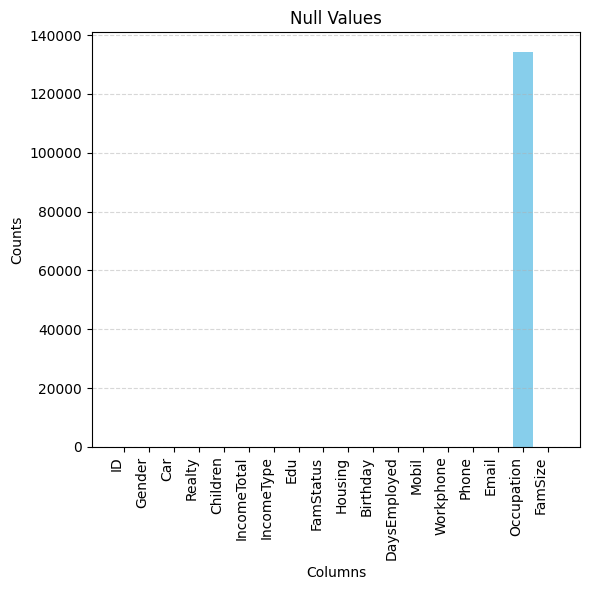

In [9]:
plt.figure(figsize=(6, 6))
plt.bar(app_null.index, app_null.values, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Counts')
plt.title('Null Values')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

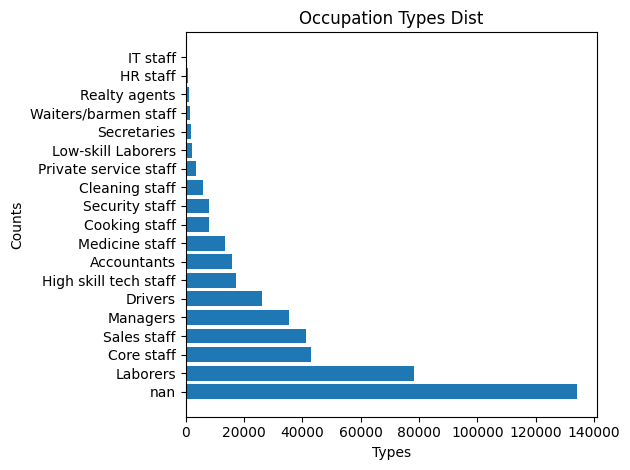

In [9]:
occupation = app['Occupation'].value_counts(dropna=False)
# occupation

plt.barh(occupation.index.astype(str), occupation.values)
plt.xlabel('Types')
plt.ylabel('Counts')
plt.title('Occupation Types Dist')
plt.tight_layout()
plt.show()

In [10]:
app['Occupation'] = app['Occupation'].replace(np.nan, "Unknown")

### Duplicate Values

In [11]:
print("duplicate rows in Application Records:", app.duplicated().sum())
print("duplicate rows in Application Records by ID:", app.duplicated(subset=['ID']).sum())
print("duplicate rows in Credit Records:",cre.duplicated().sum())

duplicate rows in Application Records: 0
duplicate rows in Application Records by ID: 47
duplicate rows in Credit Records: 0


### Drop Duplicate Values by `ID`

In [12]:
app.drop_duplicates(subset=['ID'], inplace=True)

### Convert `DaysEmployed` to `WorkYear` in `Application Records`

In [13]:
app['DaysEmployed'].value_counts()

DaysEmployed
 365243    75324
-218         262
-1678        251
-249         241
-978         240
           ...  
-7118          1
-6623          1
-10472         1
-7976          1
-13661         1
Name: count, Length: 9406, dtype: int64

In [16]:
app['WorkYear'] = app['DaysEmployed'].apply(lambda x: math.floor(-(x / 365)) if x < 0 else -1)
# -1 : unemployed
app['WorkYear'].head(3)

0    12
1    12
2     3
Name: WorkYear, dtype: int64

### Convert `Birthday` to `Age` in `Application Records`

In [17]:
app['Age'] = (-app['Birthday'] / 365).astype(int)
app['Age'].head(3)

0    32
1    32
2    58
Name: Age, dtype: int64

### Drop `DaysEmployed` and `Birthday` from `Application Records`

In [18]:
app.drop(columns=['DaysEmployed','Birthday'], inplace=True)

### Extract Categorical Features in `Application Records`

In [19]:
cat_cols = list(app.select_dtypes(include='object').columns)
cat_cols

['Gender',
 'Car',
 'Realty',
 'IncomeType',
 'Edu',
 'FamStatus',
 'Housing',
 'Occupation']

In [20]:
def show_fig(df, columns):
    n_col = 2
    n_row = math.ceil(len(columns) / 2)
    
    cmap = plt.get_cmap('Pastel1')
    colors = [cmap(i) for i in np.linspace(0, 1, len(columns))]
    
    plt.figure(figsize=(5 * n_col, 4 * n_row))
    
    for idx, item in enumerate(columns):
        val_count = df[item].value_counts(normalize=True) * 100
        
        plt.subplot(n_row, n_col, idx + 1)
        plt.title(f"{item} Dist")
        bar = plt.barh(val_count.index, val_count.values, color=colors)
        
        legend_labels = [f"{k}: {v:.2f}%" for k, v in zip(val_count.index, val_count.values)]
        
        plt.legend(bar, legend_labels, loc='best', fontsize=6)
        
    plt.tight_layout() 
    plt.show()

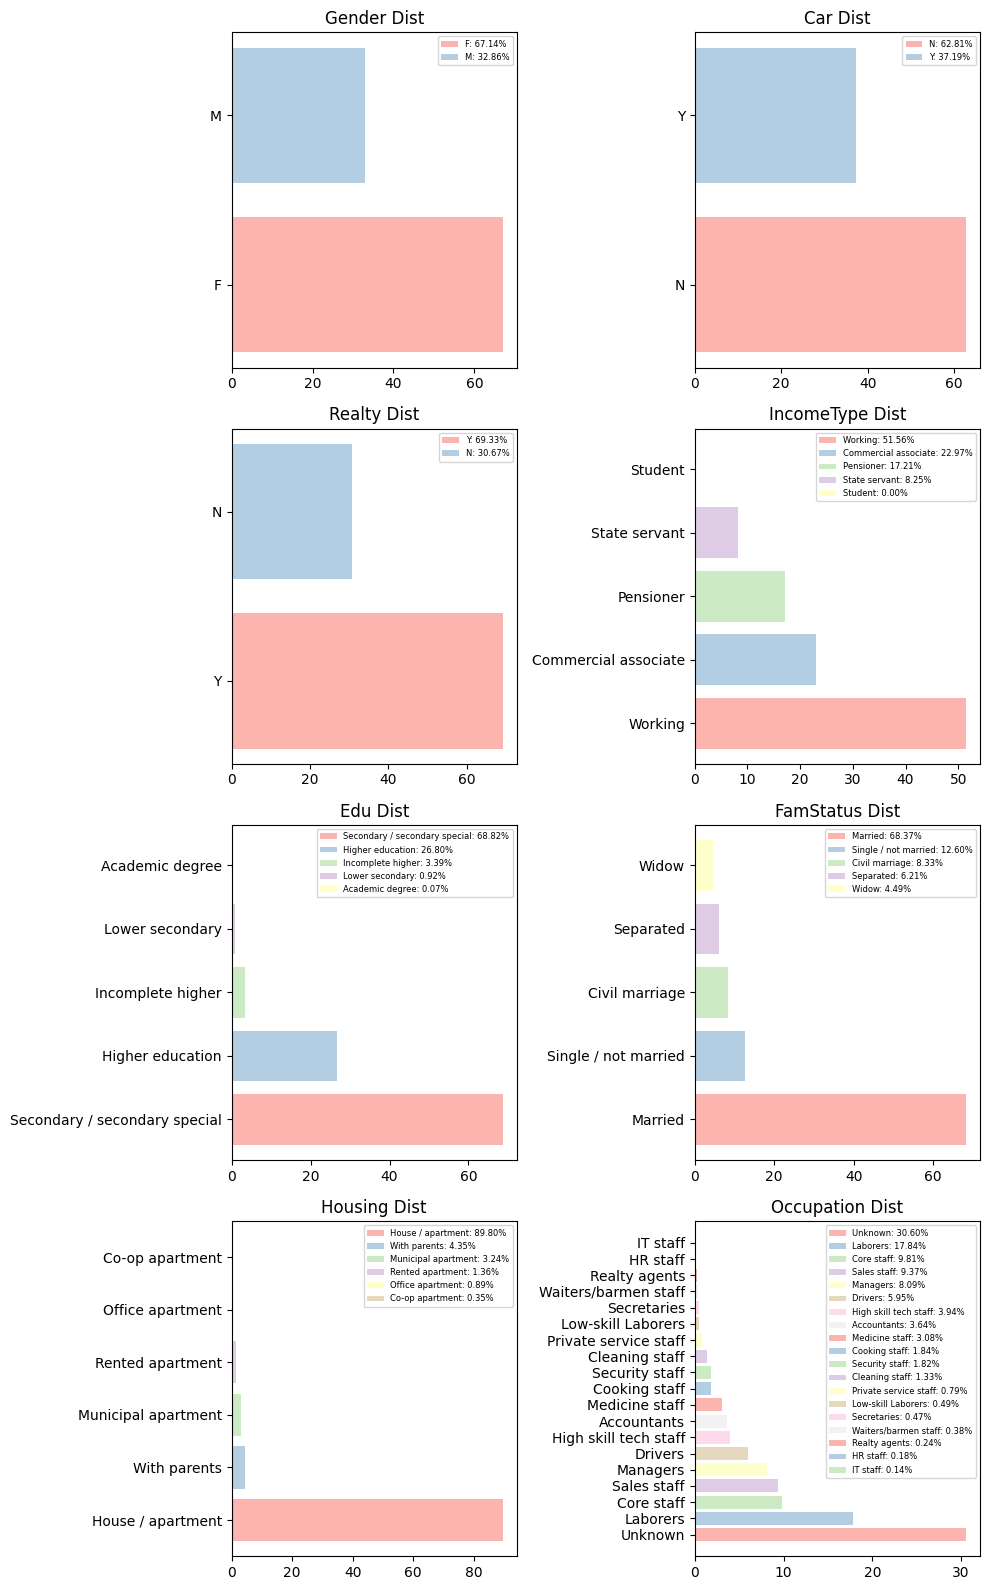

In [20]:
show_fig(app, cat_cols)

### Convert `Gender`, `Car`, `Realty` in `Application Records` to `Numerical`

In [23]:
app['Gender'] = app['Gender'].replace({'M':0, 'F':1})
app['Car'] = app['Car'].replace({'N':0, 'Y':1})
app['Realty'] = app['Realty'].replace({'N':0, 'Y':1})

### Remove `Gender`, `Car`, `Realty` from `cat_cols`

In [24]:
cat_cols.remove('Gender')
cat_cols.remove('Car')
cat_cols.remove('Realty')

In [25]:
cat_cols

['IncomeType', 'Edu', 'FamStatus', 'Housing', 'Occupation']

### Extract Numerical Features in `Application Records`

In [26]:
num_cols = list(app.select_dtypes(include=['int', 'float']).columns)

In [27]:
num_cols

['ID',
 'Gender',
 'Car',
 'Realty',
 'Children',
 'IncomeTotal',
 'Mobil',
 'Workphone',
 'Phone',
 'Email',
 'FamSize',
 'WorkYear',
 'Age']

### Clean `MONTHS_BALANCE` value in `Credit Records`

In [28]:
cre['MONTHS_BALANCE'] = abs(cre['MONTHS_BALANCE'])

### Replace `STATUS` value in `Credit Records`

In [29]:
cre['STATUS'] = cre['STATUS'].replace({'X': 0, 'C': 0})
cre['STATUS'] = cre['STATUS'].astype(int)

In [30]:
cre['STATUS'] = cre['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
cre['STATUS'].value_counts(normalize=True)
# 0 : good
# 1 : bad

STATUS
0    0.986464
1    0.013536
Name: proportion, dtype: float64

### Calculate `Number of Months per ID` credit history

In [31]:
cre_ID_Months = cre.groupby(['ID']).size().to_frame('Months').reset_index()
cre_ID_Months

,ID,Months
0,5001711,4
1,5001712,19
2,5001713,22
3,5001714,15
4,5001715,60
...,...,...
45980,5150482,18
45981,5150483,18
45982,5150484,13
45983,5150485,2


### Calculate `Number of Overdue Months per ID` credit history

In [32]:
cre_ID_Months_Overdue = cre.groupby("ID")["STATUS"].sum().to_frame("Overdue Months").reset_index()
cre_ID_Months_Overdue.sort_values(by='Overdue Months', ascending=False)

,ID,Overdue Months
26566,5085886,49
36473,5117313,48
42858,5142362,48
42857,5142361,48
35684,5116304,46
...,...,...
45980,5150482,0
45981,5150483,0
45982,5150484,0
45983,5150485,0


In [33]:
cre_ID_Months_Overdue[cre_ID_Months_Overdue['ID'] == 5001711]

,ID,Overdue Months
0,5001711,0


### Create `New Credit Records` dataframe

In [34]:
new_cre = pd.DataFrame(cre.groupby(["ID"]).agg(max)).reset_index()

In [35]:
new_cre.head(3)

,ID,MONTHS_BALANCE,STATUS
0,5001711,3,0
1,5001712,18,0
2,5001713,21,0


In [38]:
print("New Credit Records | column:", new_cre.shape[1], "| row:", new_cre.shape[0])
print("New Credit Records ID has same value as Credit Records ID" if new_cre.shape[0] == cre['ID'].nunique() else "Not Same")

New Credit Records | column: 3 | row: 45985
New Credit Records ID has same value as Credit Records ID


### Merge `Application Records` and `New Credit Records` dataframe

In [39]:
data = app.merge(new_cre, on='ID', how='inner')
data.head(2)

,ID,Gender,Car,Realty,Children,IncomeTotal,IncomeType,Edu,FamStatus,Housing,Mobil,Workphone,Phone,Email,Occupation,FamSize,WorkYear,Age,MONTHS_BALANCE,STATUS
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,12.443836,32,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,12.443836,32,14,1


In [40]:
data.shape

(36457, 20)

### Check `STATUS` info

In [41]:
print(data['STATUS'].isna().sum())
print(data['STATUS'].dtypes)
print(data['STATUS'].unique())
print(data['STATUS'].value_counts())
print(data['STATUS'].value_counts(normalize=True))

0
int64
[1 0]
STATUS
0    32166
1     4291
Name: count, dtype: int64
STATUS
0    0.8823
1    0.1177
Name: proportion, dtype: float64


In [43]:
print(data.isna().sum())

ID                0
Gender            0
Car               0
Realty            0
Children          0
IncomeTotal       0
IncomeType        0
Edu               0
FamStatus         0
Housing           0
Mobil             0
Workphone         0
Phone             0
Email             0
Occupation        0
FamSize           0
WorkYear          0
Age               0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


### Drop `MONTHS_BALANCE` Column

In [44]:
data.drop('MONTHS_BALANCE', axis=1, inplace=True)
data.head(2)

,ID,Gender,Car,Realty,Children,IncomeTotal,IncomeType,Edu,FamStatus,Housing,Mobil,Workphone,Phone,Email,Occupation,FamSize,WorkYear,Age,STATUS
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,12.443836,32,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Unknown,2.0,12.443836,32,1


### Splitting Train and Test Data

In [45]:
X = data.drop('STATUS', axis=1)
y = data['STATUS']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [48]:
print("train size | X:", X_train.shape[0], "y:", y_train.shape[0])
print("test size | X:", X_test.shape[0], "y:", y_test.shape[0])

train size | X: 29165 y: 29165
test size | X: 7292 y: 7292


### Scaling Numerical Column and Encoding Categorical Columns

In [49]:
scaler =  MinMaxScaler()
encode = OneHotEncoder(handle_unknown='ignore')

### Preprocessing with ColumnTransform

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, num_cols),
        ('cat', encode, cat_cols)
    ]
)

### Using SMOTE

In [51]:
smote = SMOTE(random_state=42)

### RandomForest Model

In [52]:
pipe_rf = Pipeline([
    ('preprocess', preprocessor),
    ('smote', smote),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}

In [53]:
grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5, n_jobs=-1, scoring='f1')
grid_rf.fit(X_train, y_train)

print("Random Forest Best Params:", grid_rf.best_params_)

Random Forest Best Params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}


In [54]:
model_rf = grid_rf.best_estimator_

### Evaluate Model

In [59]:
def evaluation(model_name):
    # acc = accuracy_score(y_test, model_name.predict(X_test))
    report = classification_report(y_test, model_name.predict(X_test))
    conf = confusion_matrix(y_test, model_name.predict(X_test))
    # print(f"{model_name} Accuracy : {acc*100:.2f}%")
    print(f"{report}")
    print("Confusion Matrix")
    print(f"{conf}")
    
# y_test : True labels (correct answers)
# model.predict(X_test) : Predicted labels from model

### Evaluate __RandomForest Model__

In [60]:
evaluation(model_rf)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6420
           1       0.47      0.41      0.44       872

    accuracy                           0.87      7292
   macro avg       0.70      0.67      0.68      7292
weighted avg       0.87      0.87      0.87      7292

Confusion Matrix
[[6025  395]
 [ 517  355]]


### Prediction Pipeline __RandomForest Model__

In [ ]:
pred_preprocess = model_rf.named_steps['preprocess']
pred_model = model_rf.named_steps['model']

In [ ]:
pipe_rf_final = SklearnPipeline([
    ('preprocess', pred_preprocess),
    ('model', pred_model)               
])

In [ ]:
# retrain, see the reports and predict x_test
# model_rf.fit(X_train, y_train)

### DecisionTree Model

In [69]:
pipe_dt = Pipeline([
    ('preprocess', preprocessor),
    ('smote', smote),
    ('model', DecisionTreeClassifier(random_state=42))
])

param_dt = {
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2, 4],  # Optional but commonly tuned
    'model__criterion': ['gini', 'entropy']  # Or ['gini', 'entropy', 'log_loss'] in newer versions
}

In [70]:
grid_dt = GridSearchCV(pipe_dt, param_dt, cv=5, n_jobs=-1, scoring='f1')
grid_dt.fit(X_train, y_train)

print("Decision Tree Best Params:", grid_dt.best_params_)

Decision Tree Best Params: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


In [71]:
model_dt = grid_dt.best_estimator_

### Evaluate __DecisionTree Model__

In [72]:
evaluation(model_dt)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6420
           1       0.38      0.44      0.41       872

    accuracy                           0.85      7292
   macro avg       0.65      0.67      0.66      7292
weighted avg       0.86      0.85      0.85      7292

Confusion Matrix
[[5795  625]
 [ 485  387]]


### KNN Model

In [61]:
pipe_knn = Pipeline([
    ('preprocess', preprocessor),
    ('smote', smote),
    ('model', KNeighborsClassifier())
])

param_knn = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

In [62]:
grid_knn = GridSearchCV(pipe_knn, param_knn, cv=5, n_jobs=-1, scoring='f1')
grid_knn.fit(X_train, y_train)

print("KNN Best Params:", grid_knn.best_params_)

KNN Best Params: {'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'distance'}


In [63]:
model_knn = grid_knn.best_estimator_

### Evaluate __KNN Model__

In [ ]:
evaluation(model_knn)

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      6420
           1       0.40      0.47      0.43       872

    accuracy                           0.85      7292
   macro avg       0.66      0.69      0.67      7292
weighted avg       0.86      0.85      0.86      7292

Confusion Matrix
[[5793  627]
 [ 461  411]]


### LogisticRegression Model

In [65]:
pipe_logreg = Pipeline([
    ('preprocess', preprocessor),
    ('smote', smote),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

param_logreg = [
    {
        'model__solver': ['newton-cg', 'lbfgs', 'sag'],
        'model__penalty': ['l2', 'none'],
        'model__C': [0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__solver': ['liblinear'],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced']
    },
    {
        'model__solver': ['saga'],
        'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'model__C': [0.01, 0.1, 1, 10],
        'model__class_weight': [None, 'balanced'],
        'model__l1_ratio': [0, 0.5, 1]  # only for elasticnet
    }
]

In [66]:
grid_logreg = GridSearchCV(pipe_logreg, param_logreg, cv=5, n_jobs=-1, scoring='f1')
grid_logreg.fit(X_train, y_train)

print("Logistic Regression Best Params:", grid_logreg.best_params_)

Logistic Regression Best Params: {'model__C': 0.01, 'model__class_weight': None, 'model__l1_ratio': 0.5, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}


In [67]:
model_logreg = grid_logreg.best_estimator_

### Evaluate __LogisticRegression Model__

In [68]:
evaluation(model_logreg)

              precision    recall  f1-score   support

           0       0.89      0.53      0.67      6420
           1       0.13      0.53      0.21       872

    accuracy                           0.53      7292
   macro avg       0.51      0.53      0.44      7292
weighted avg       0.80      0.53      0.61      7292

Confusion Matrix
[[3433 2987]
 [ 414  458]]


### Save Model

In [ ]:
joblib.dump(pipe_rf_final, 'random_forest_model.pkl')

['random_forest_model.pkl']

### Load Model

In [ ]:
# model_rf = joblib.load('random_forest_model.pkl')